In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op
from scipy import stats
import emcee
import corner
from scipy.stats import chisquare
%matplotlib inline

In [2]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [3]:
def c4(em):
    return np.sqrt(2/(em-1.))*gamma(em/2.)/gamma((em-1.)/2)

In [4]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[df['D (Mpc)']<500]
df=df[np.isfinite(df.err)]
df=df[df['D (Mpc)']>35]

In [5]:
df.shape

(54398, 15)

In [6]:
df.head()

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
4,NaN,3,2,UGC 12889,34.16,0.40,68.0,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,mean
5,NaN,4,2,UGC 12889,34.66,0.45,85.6,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,K
6,NaN,5,2,UGC 12889,34.68,0.47,86.1,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,H
7,NaN,6,2,UGC 12889,34.70,0.46,86.9,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,J
8,NaN,7,3,KUG 2357+228,33.52,0.20,50.6,Tully-Fisher,2013AJ....146...86T,NaN,NaN,74.4,NaN,33,NaN


In [7]:
for i in np.unique(df.Method):
    df1=df[df.Method==i]
    print i,df1.shape

AGN time lag (24, 15)
Black Hole (12, 15)
CMD (3, 15)
Cepheids (4, 15)
D-Sigma (815, 15)
Dwarf Galaxy Diameter (6, 15)
FP (11038, 15)
Faber-Jackson (527, 15)
GCLF (36, 15)
GeV TeV ratio (3, 15)
H I + optical distribution (1, 15)
HII region diameter (1, 15)
IRAS (2089, 15)
Maser (6, 15)
Ring Diameter (71, 15)
SBF (236, 15)
SGRB (5, 15)
SNII optical (319, 15)
SNII radio (6, 15)
SNIa (1988, 15)
SZ effect (5, 15)
Sosies (129, 15)
Tertiary (92, 15)
Tully est (264, 15)
Tully-Fisher (36718, 15)


In [8]:
np.unique(df1.Method)

array(['Tully-Fisher'], dtype=object)

In [9]:
listcut=np.unique(df1['Galaxy ID'])

In [10]:
listcut

array(['2MASX J00024069+0846251', '2MASX J00041398-5113247',
       '2MASX J00062236-5010027', ..., 'WISEP J041245.99+294612.5',
       'WKK 2029', 'ZwCl 1115.2+3013 03'], dtype=object)

In [12]:
disterr=0.461*df1['D (Mpc)']*df1.err

In [14]:
import sklearn.mixture
gmm = sklearn.mixture.GMM()

In [881]:
%%time
errlist=np.zeros((len(listcut),9))
k=0
nbins=1000
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>11):
        data=np.array([])
        dummy=df1[dfilter]
        for i in dummy.D:
            otherfilter=(dummy.D==i)
            AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
            data=np.hstack((data,AA))            
        dumerr=disterr[dfilter]
        em=len(df1[dfilter])
        r = gmm.fit(data[:, np.newaxis])
        errlist[k,0]=r.means_[0, 0]/1e6
        errlist[k,1]=em
        errlist[k,2]=np.sqrt(r.covars_[0, 0])/1e6
        errlist[k,3]=np.percentile(data, 50)/1e6
        errlist[k,4]=np.percentile(data, 84)/1e6-errlist[k,3]
        errlist[k,5]=errlist[k,3]-np.percentile(data, 16)/1e6
        errlist[k,6]=dumerr.mean()
        errlist[k,7]=dummy['D (Mpc)'].mean()
        errlist[k,8]=dumerr.min()
    k+=1


CPU times: user 23.8 s, sys: 0 ns, total: 23.8 s
Wall time: 23.9 s


In [575]:
(errlist[:,0]!=0).sum()

442

In [402]:
errlist.shape

(9123, 9)

In [1310]:
filter=(errlist[:,0][(errlist[:,0]!=0)]<500)

In [1458]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -5 < b < 5:
        return 0.0
    return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

0.984670399624 -0.118774263576


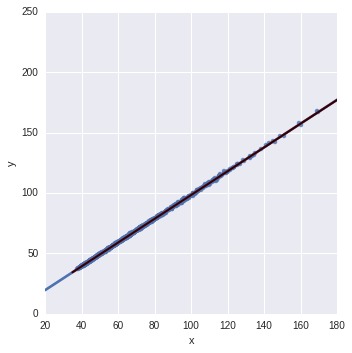

In [22]:
# gmm-fitted mean vs. unweighted mean
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,7]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlim(0,aaa)
#plt.ylim(0,aaa)

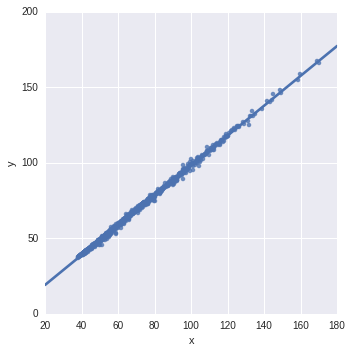

In [247]:
# weighted vs. 50% percentile
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,3]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlim(0,aaa)
#plt.ylim(0,aaa)

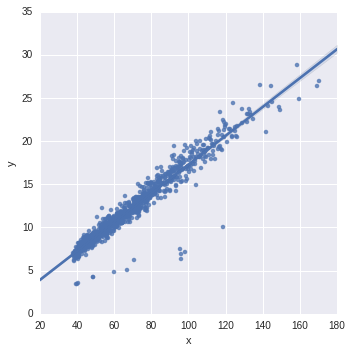

In [248]:
# mean reported error
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,6][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)

0.194389612048 0.0227160657364


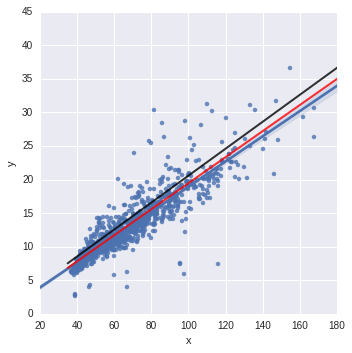

In [50]:
# 16% vs 50%
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,5][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

0.201641440997 2.45550281687


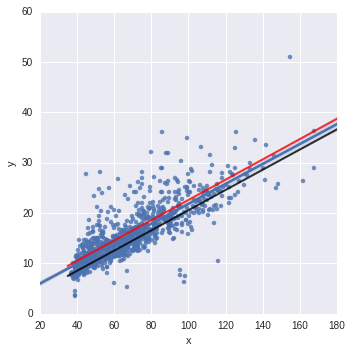

In [51]:
# 84%-16% vs 50%
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,4][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

0.198904342911 0.730635002123
0.198904344148 0.730635001986


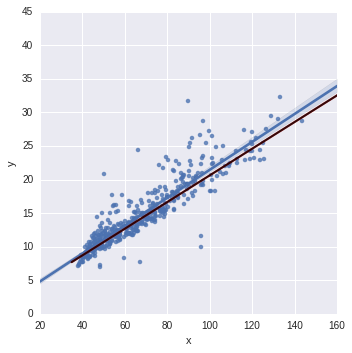

In [1460]:
# gmm-fitted sigma
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,2]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
print m_ls,b_ls
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

(0, 35)

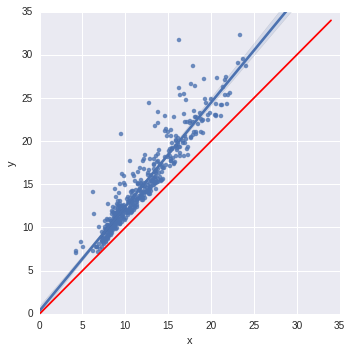

In [1453]:
# gmm-fitted sigma vs reported error
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,2]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

In [1496]:
filter=(errlist[:,0][(errlist[:,0]!=0)]>0)
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]
yerr=errlist[(errlist[:,0]!=0)][:,6][filter]
# yerr=y_me[filter] did I find convergence for an iteratively predictive model? eek!

In [1497]:
def lnlike(theta, x, y,yerr):
    m ,b,n,f = theta
    model = m * x +b+n*x**2+f*yerr
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b,n,f = theta
    if -1 < m < 1 and -30 < b < 30 and -10<n<10 and -10<f<10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)

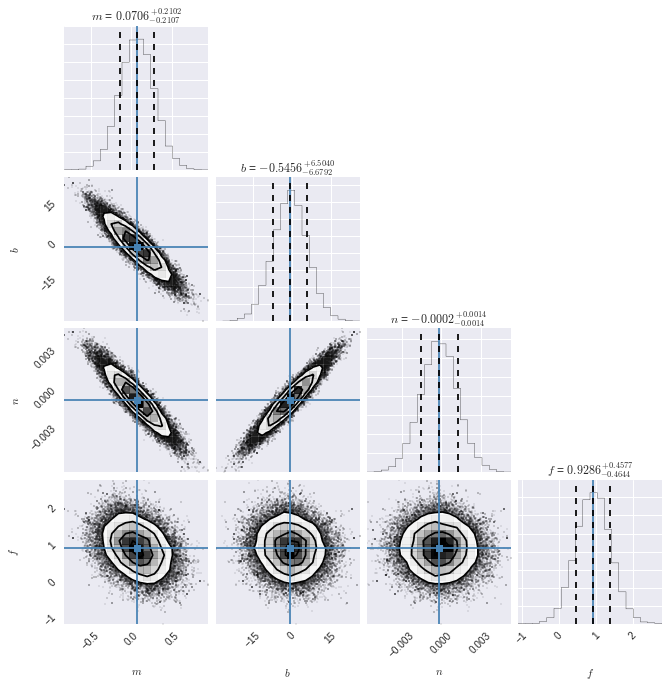

In [1498]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1,1,1], args=(x, y,yerr))
m_ml, b_ml,n_ml,f_ml= result["x"]
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 1000);
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
meanest=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$n$","$f$"],
                      truths=[meanest[0], meanest[1],meanest[2],meanest[3]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

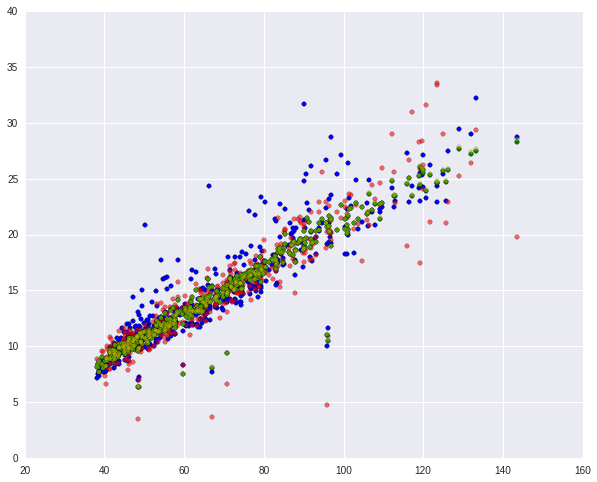

In [1499]:
plt.figure(figsize=(10,8))

plt.scatter(x,y)
AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr
plt.scatter(x,y_sim,c='r',alpha=0.6)
y_ml=m_ml*x+b_ml+n_ml*x**2+f_ml*yerr
y_me=meanest[0]*x+meanest[1]+meanest[2]*x**2+meanest[3]*yerr
plt.scatter(x,y_ml,c='g')
plt.scatter(x,y_me,c='y',alpha=0.4)

13715.2177267 20000 3.57752482131e-276


(array([   66.,   395.,   852.,  1692.,  2508.,  1273.,  2006.,   602.,
          495.,   111.]),
 array([ 0.08564622,  0.17485903,  0.26407184,  0.35328466,  0.44249747,
         0.53171028,  0.62092309,  0.71013591,  0.79934872,  0.88856153,
         0.97777434]),
 <a list of 10 Patch objects>)

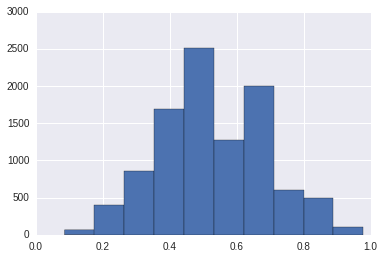

In [1500]:
listaksst=[]
listakspv=[]
rvs1 = (y)
ndsets=10000
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr
    rvs3 = (y_sim)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1])
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
cpval=-2*(np.log(listakspv)).sum()
print cpval, 2*ndsets,stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)

Bayesian p-value: 0.1572
Rejection rate (%): 5.34


(0, 200)

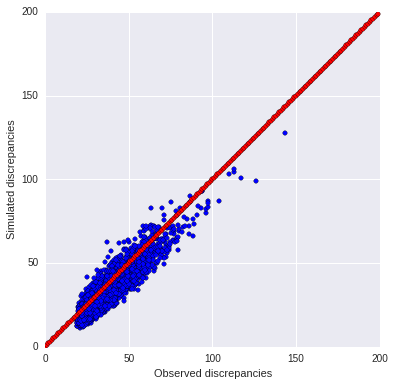

In [1501]:
discobs=[]
discsim=[]
for m,b,n,f in samples[np.random.randint(len(samples), size=5000)]:
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr
    yexp=m*x+b+n*x**2+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim)
print "Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs)
print "Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim)
ppp=np.arange(200)
plt.scatter(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,200)
plt.ylim(0,200)

In [1491]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=2))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)
    print autocorr.mean(),autocorr.std()

AutocorrError: The chain is too short to reliably estimate the autocorrelation time

In [1502]:
observed_values=y
expected_values=y_me
chisquare(f_obs=observed_values, f_exp=expected_values)

Power_divergenceResult(statistic=88.983676226856971, pvalue=1.0)

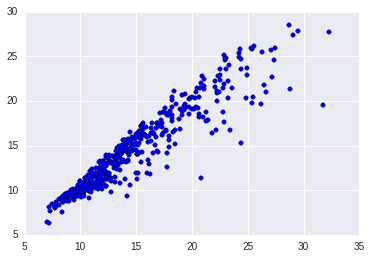

In [1503]:
plt.scatter(observed_values,expected_values)

(0, 40)

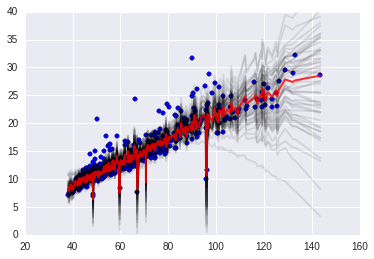

In [1504]:
xl, yerrl = (list(x) for x in zip(*sorted(zip(x, yerr))))
xl,yerrl=np.asarray(xl),np.asarray(yerrl)
for m, b, n, f in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(xl, m*xl+b+n*xl**2+f*yerrl, color="k", alpha=0.1)
plt.plot(xl, meanest[0]*xl+meanest[1]+meanest[2]*xl**2+meanest[3]*yerrl, color="r", lw=2, alpha=0.8)
plt.scatter(x,y)
plt.ylim(0,40)

In [1505]:
negsim=[]
for m, b, n, f in samples[np.random.randint(len(samples), size=5000)]:
    negsim.append((m*xl+b+n*x**2+f*yerrl<0).sum()*100./len(x))
negsim=np.asarray(negsim)
negsim.mean()

2.2733484162895929

(0, 35)

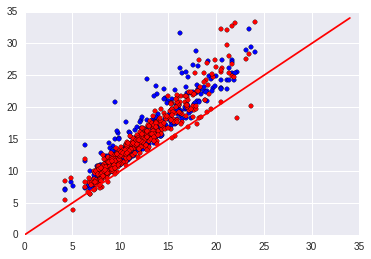

In [1506]:
# gmm-fitted sigma vs reported error
AAA=samples[np.random.randint(len(samples), size=len(x))]
xx=errlist[(errlist[:,0]!=0)][:,6][filter]
yy=errlist[(errlist[:,0]!=0)][:,2][filter]
plt.scatter(xx,yy)
plt.scatter(xx,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr,c='r')
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

In [1507]:
np.savetxt('posteriorpredictive.txt',samples)

In [876]:
%%time
err4mod=np.zeros((len(listcut),9))
k=0
nbins=1000
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if 2<len(df1[dfilter])<12:
        data=np.array([])
        dummy=df1[dfilter]
        for i in dummy.D:
            otherfilter=(dummy.D==i)
            AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
            data=np.hstack((data,AA))            
        dumerr=disterr[dfilter]
        em=len(df1[dfilter])
        r = gmm.fit(data[:, np.newaxis])
        err4mod[k,0]=r.means_[0, 0]/1e6
        err4mod[k,1]=em
        err4mod[k,2]=np.sqrt(r.covars_[0, 0])/1e6
        err4mod[k,3]=np.percentile(data, 50)/1e6
        err4mod[k,4]=np.percentile(data, 84)/1e6-errlist[k,3]
        err4mod[k,5]=errlist[k,3]-np.percentile(data, 16)/1e6
        err4mod[k,6]=dumerr.mean()
        err4mod[k,7]=dummy['D (Mpc)'].mean()
        err4mod[k,8]=dumerr.min()
    k+=1


CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s


In [1508]:
(err4mod[:,0]!=0).sum()

5321

In [1509]:
filter=(err4mod[:,0][(err4mod[:,0]!=0)]<500)

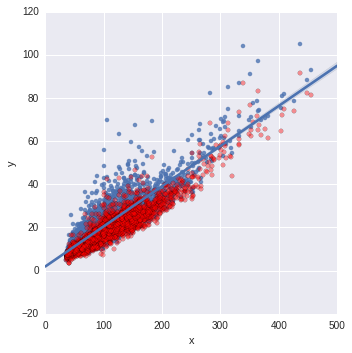

In [1510]:
# gmm-fitted sigma
xx=err4mod[(err4mod[:,0]!=0)][:,0][filter]
yy=err4mod[(err4mod[:,0]!=0)][:,2][filter]
df5=pd.DataFrame({'x' : xx, 'y': yy})
sns.lmplot(x="x", y="y", data=df5)
plt.scatter(xx,err4mod[(err4mod[:,0]!=0)][:,6][filter],c='r',alpha=0.4)

In [1511]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))

0.198904579953 0.730619762739


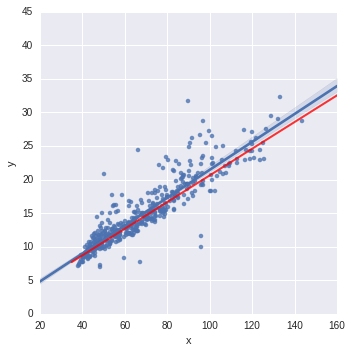

In [1512]:
# gmm-fitted sigma
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,2]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#A = np.vstack((np.ones_like(x), x)).T
#C = np.diag(y * y)
#cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
#b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
#print m_ls,b_ls
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
#plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

In [1513]:
observed_values=y
expected_values=m_ml*x+b_ml
chisquare(f_obs=observed_values, f_exp=expected_values)

Power_divergenceResult(statistic=134.8897453734993, pvalue=1.0)

(0, 80)

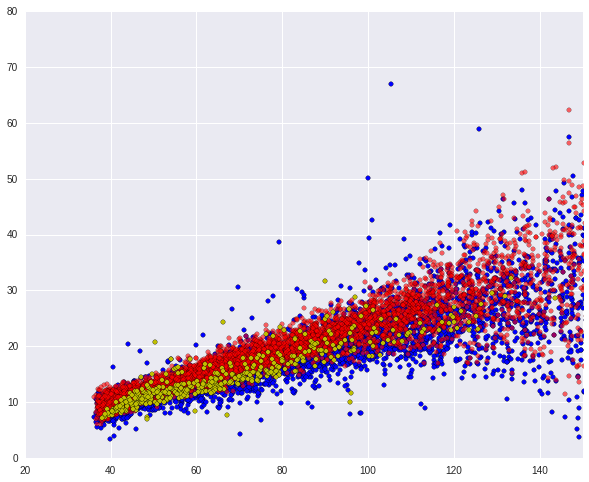

In [1514]:
plt.figure(figsize=(10,8))
yyerr1=err4mod[(err4mod[:,0]!=0)][:,6][filter]
yyerr2=m_ml*xx+b_ml
AAA=samples[np.random.randint(len(samples), size=len(xx))]
yy_sim1=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr1
yy_sim2=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr2

plt.scatter(xx,yy_sim1)
plt.scatter(xx,yy_sim2,c='r',alpha=0.6)
#plt.scatter(xx,err4mod[(err4mod[:,0]!=0)][:,2][filter],c='k',alpha=0.4)
#plt.scatter(xx,yyerr2,c='k')
plt.scatter(x,y,c='y')
plt.xlim(20,150)
plt.ylim(0,80)

(0, 80)

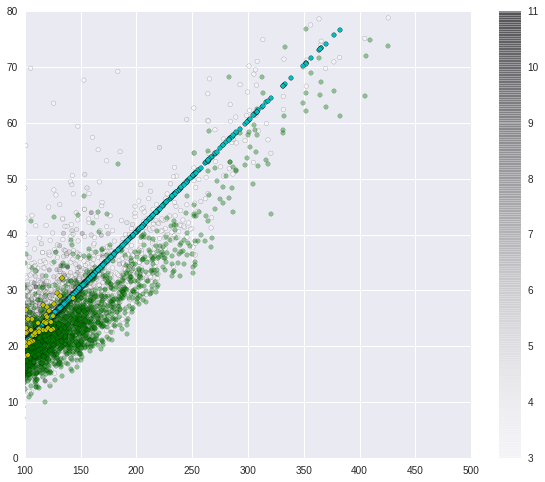

In [1515]:
filter=err4mod[(err4mod[:,0]!=0)][:,1]>2
plt.figure(figsize=(10,8))
yyerr1=err4mod[(err4mod[:,0]!=0)][:,2]
yyerr2=m_ml*xx+b_ml
AAA=samples[np.random.randint(len(samples), size=len(xx))]
yy_sim1=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr1
yy_sim2=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr2

#plt.scatter(xx,yy_sim1)
#plt.scatter(xx,yy_sim2,c='r',alpha=0.6)
plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,2][filter],c=err4mod[(err4mod[:,0]!=0)][:,1][filter],alpha=0.4)
plt.colorbar()

plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,6][filter],c='g',alpha=0.4)

#plt.scatter(xx,err4mod[(err4mod[:,0]!=0)][:,6][filter],c='g',alpha=0.4)
plt.scatter(xx,yyerr2,c='c')
plt.scatter(x,y,c='y')
plt.xlim(100,500)
plt.ylim(0,80)

In [1517]:
for i in range(11):
    print i, (err4mod[(err4mod[:,0]!=0)][:,1][filter]==i).sum()    

0 0
1 0
2 0
3 1940
4 1295
5 499
6 348
7 356
8 355
9 233
10 172


In [1518]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -10 < b < 10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

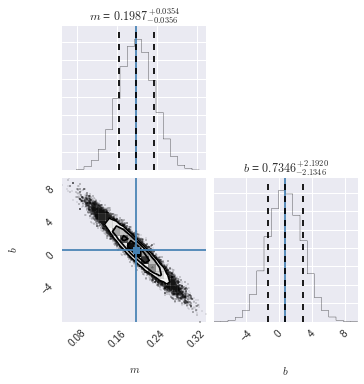

In [1519]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1], args=(x, y))
m_ml, b_ml= result["x"]
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y))
sampler.run_mcmc(pos, 1000);
samplesli = sampler.chain[:, 100:, :].reshape((-1, ndim))
meanestli=samplesli.mean(axis=0)
fig = corner.corner(samplesli, labels=["$m$", "$b$"],
                      truths=[meanestli[0], meanestli[1]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

(0, 100)

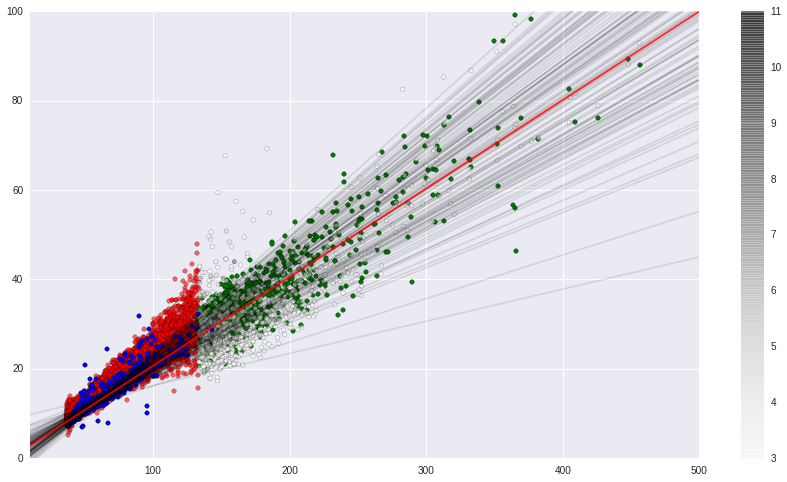

In [1559]:
plt.figure(figsize=(15,8))
xl = np.arange(500)
for m, b in samplesli[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, meanestli[0]*xl+meanestli[1], color="r", lw=2, alpha=0.8)
cutoff=x.max()-10
plt.scatter(xx[xx<cutoff],yy_sim2[xx<cutoff],c='r',alpha=0.6)
AAA=samplesli[np.random.randint(len(samplesli), size=len(xx))]
yy_siml=AAA[:,0]*xx+AAA[:,1]
plt.scatter(xx[xx>cutoff],yy_siml[xx>cutoff],c='g')
#plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,2][filter],c='k',alpha=0.3)
plt.scatter(xx[xx>cutoff],err4mod[(err4mod[:,0]!=0)][:,2][xx>cutoff],c=err4mod[(err4mod[:,0]!=0)][:,1][xx>cutoff],alpha=0.5)
plt.colorbar()
plt.scatter(x,y)
plt.xlim(10,500)
plt.ylim(0,100)

In [1556]:
x.max()

143.56965002992885

# Hasta aquí

In [1512]:
yerr=errlist[(errlist[:,0]!=0)][:,6] # average - pasa el ks-test pero el p-value de discrepancias no
# pasa el ks test (p<0.05 con un draw para cada tres parametros). con tres draw no pasa el ks-test
# con uno o con tres draws a veces predice valores negativos para el error :(
# pidiendo positividad en los parámetros no funciona el mcmc
# se podría re-simular pidiendo positividad en y cuando un dato salga malo?

In [1520]:
yerr=errlist[(errlist[:,0]!=0)][:,8] 
# minimum - pasa el ks-test casi siempre pero su estadística no es chi-2 (p~1) ni con un draw ni con tres draw
# p-value bayesiano no muestra inconsistencia, (con tres draw para tres parametros), p~0.9<0.975 pero a veces genera
# errores negativos
# con un solo draw el p-value bayesiano si muestra inconsistencia
# con un prior pidiendo positividad de los parámetros, no pasamos el ks-test
# pero para tres draws el bayesian p-value es muy bueno p~0.6

In [1521]:
def lnlike(theta, x, y,yerr):
    m ,b,f = theta
    model = m * x +b+f*yerr
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b,f = theta
    if 0 < m < 1 and 0 < b < 5 and 0<f<10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)


In [1522]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls,0.5], args=(x, y,yerr))
m_ml, b_ml,f_ml= result["x"]
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 1000);
sampler.chain.shape

(100, 1000, 3)

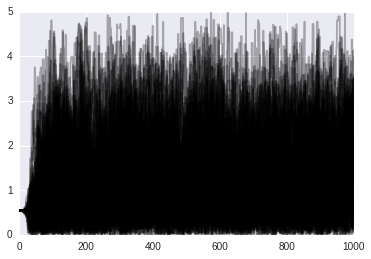

In [1523]:
# b
res=plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)

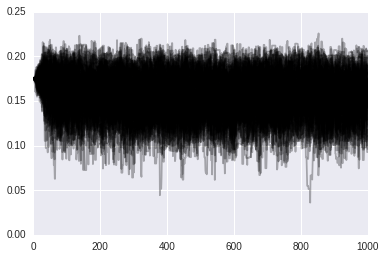

In [1524]:
# m
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

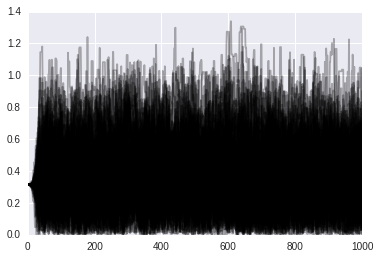

In [1525]:
# f
res=plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)

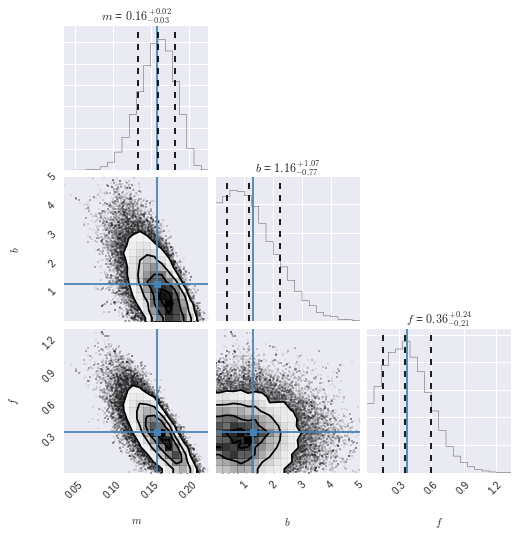

In [1526]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
meanest=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],
                      truths=[meanest[0], meanest[1],meanest[2]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.2f')

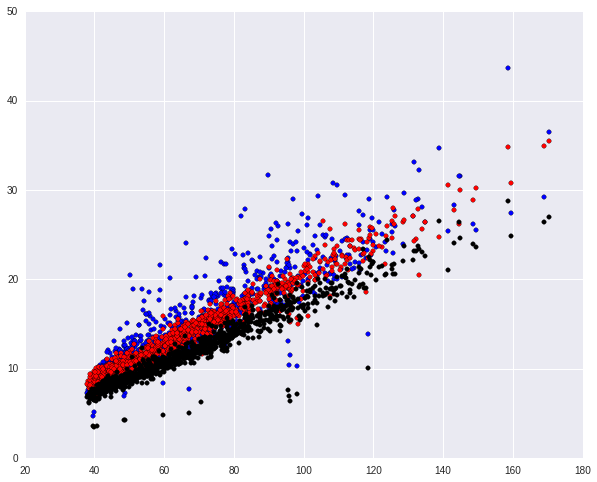

In [1534]:
plt.figure(figsize=(10,8))
AAA=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr,c='r')
plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [1540]:
listaksst=[]
listakspv=[]
y_ml=meanest[0]*xl+meanest[1]+meanest[2]*yerrl
rvs1 = (y-y_ml)
ndsets=5000
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
#    BBB=samples[np.random.randint(len(samples), size=len(x))]
#    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    rvs3 = (y_sim-y_ml)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1])
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
# crit=34.8 for n=25
cpval=-2*(np.log(listakspv)).sum()

In [1541]:
cpval=-2*(np.log(listakspv)).sum()
stats.chi2.cdf(cpval, 2*ndsets)

1.0

(array([   1.,    5.,   27.,  179.,  340.,  266.,  101.,   38.,   11.,    2.]),
 array([-26.24850745, -20.77099309, -15.29347872,  -9.81596436,
         -4.33844999,   1.13906438,   6.61657874,  12.09409311,
         17.57160748,  23.04912184,  28.52663621]),
 <a list of 10 Patch objects>)

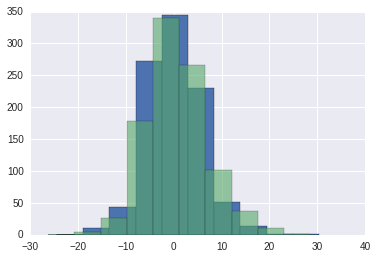

In [1542]:
plt.hist(y_sim-y_ml)
plt.hist(y-y_ml,alpha=0.6)

In [1543]:
(listakspv>0.05).sum()

4944

(array([  104.,   685.,  1398.,  1120.,   958.,   325.,   318.,    51.,
           23.,    18.]),
 array([ 0.02442597,  0.05646347,  0.08850097,  0.12053847,  0.15257597,
         0.18461347,  0.21665096,  0.24868846,  0.28072596,  0.31276346,
         0.34480096]),
 <a list of 10 Patch objects>)

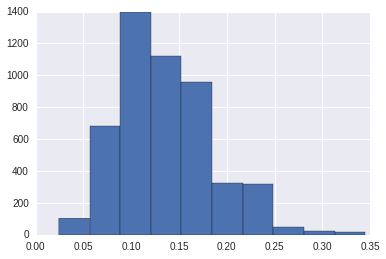

In [1544]:
stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)

(0, 35)

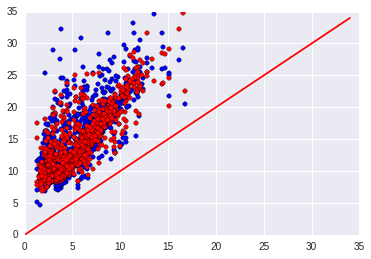

In [1548]:
# gmm-fitted sigma vs reported error
AAA=samples[np.random.randint(len(samples), size=len(x))]

xx=errlist[(errlist[:,0]!=0)][:,8][filter]
yy=errlist[(errlist[:,0]!=0)][:,2][filter]
plt.scatter(xx,yy)
plt.scatter(xx,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr,c='r')
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

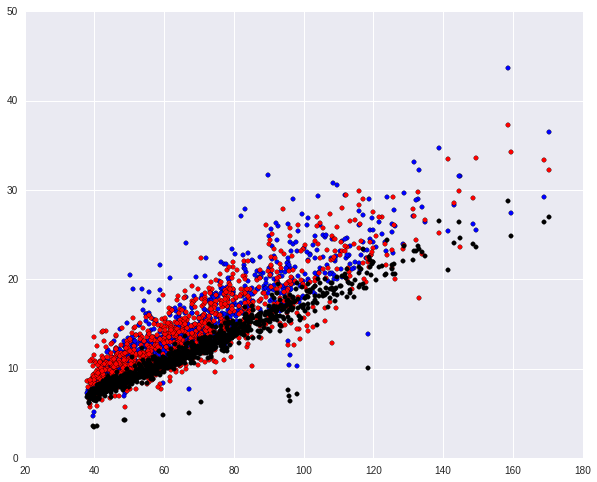

In [1506]:
plt.figure(figsize=(10,8))
AAA=samples[np.random.randint(len(samples), size=len(x))]
BBB=samples[np.random.randint(len(samples), size=len(x))]
CCC=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+BBB[:,1]+CCC[:,2]*yerr,c='r')

plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [1507]:
discobs=[]
discsim=[]
for m,b,f in samples[np.random.randint(len(samples), size=50000)]:
    b=samples[np.random.randint(len(samples), size=1)][:,1]
    f=samples[np.random.randint(len(samples), size=1)][:,2]
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    BBB=samples[np.random.randint(len(samples), size=len(x))]
    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+BBB[:,1]+CCC[:,2]*yerr
    yexp=m*x+b+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

In [1508]:
np.isnan(discsim).sum()

0

0.63602


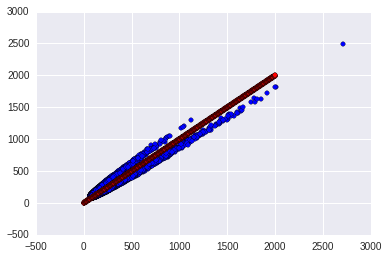

In [1511]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./(len(discobs)-np.isnan(discsim).sum())
ppp=np.arange(2000)
plt.scatter(ppp,ppp,c='r')

In [1556]:
discobs=[]
discsim=[]
for m,b,f in samples[np.random.randint(len(samples), size=50000)]:
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    yexp=m*x+b+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

In [1557]:
np.isnan(discsim).sum()

0

0.0


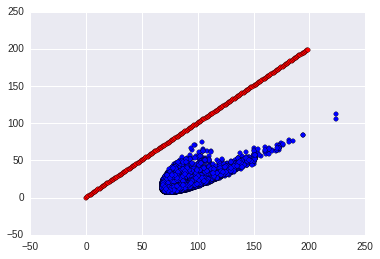

In [1559]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./len(discobs)
ppp=np.arange(200)
plt.scatter(ppp,ppp,c='r')

In [1064]:
%%time
from scipy.optimize import curve_fit

hist, bin_edges = np.histogram(data, density=True,bins=nbins)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
p0 = [hist.max(), data.mean(), data.std()]
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
hist_fit = gauss(bin_centres, *coeff)
print 'Fitted mean = ', coeff[1]/1e6
print 'Fitted standard deviation = ', coeff[2]/1e6
plt.show()

Fitted mean =  80.2544179399
Fitted standard deviation =  18.4722080092
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 134 ms


https://hflog.wordpress.com/2014/04/01/how-to-perform-a-chi-squared-goodness-of-fit-test-in-python/